In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools #used for trends
import statsmodels.api as sm #used for statistics like chi test etc
% matplotlib inline


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dataset = pd.read_excel('/content/Superstore.xls')

In [ ]:
dataset.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [ ]:
dataset.dtypes

Row ID                    int64
Order ID                 object
Order Date       datetime64[ns]
Ship Date        datetime64[ns]
Ship Mode                object
Customer ID              object
Customer Name            object
Segment                  object
Country                  object
City                     object
State                    object
Postal Code               int64
Region                   object
Product ID               object
Category                 object
Sub-Category             object
Product Name             object
Sales                   float64
Quantity                  int64
Discount                float64
Profit                  float64
dtype: object

In [ ]:
set(dataset['Category']) #Converting the categorical values to a set

{'Furniture', 'Office Supplies', 'Technology'}

In [ ]:
set(dataset['Segment'])

{'Consumer', 'Corporate', 'Home Office'}

In [ ]:
set(dataset['Country'])

{'United States'}

#Data Preprocessing

We shall first analyse time series of furniture sales followed by other categories

In [ ]:
furniture = dataset.loc[dataset['Category']=='Furniture']


#This shows that we have time series data of 4 yrs for furniture sales
print(furniture['Order Date'].min()) #first date it was sold
print(furniture['Order Date'].max()) #last date it was sold





2014-01-06 00:00:00
2017-12-30 00:00:00


In [ ]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City',
        'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity',
        'Discount','Profit']
furniture.drop(cols, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
furniture.columns

Index(['Order Date', 'Sales'], dtype='object')

In [ ]:
furniture.sort_values('Order Date')
furniture.isna().sum()

Order Date    0
Sales         0
dtype: int64

In [ ]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [ ]:
Office_Supplies = dataset.loc[dataset['Category']=='Office Supplies']
print(Office_Supplies['Order Date'].min())
print(Office_Supplies['Order Date'].max())

2014-01-03 00:00:00
2017-12-30 00:00:00


In [ ]:
Technology = dataset.loc[dataset['Category']=='Technology']
print(Technology['Order Date'].min())
print(Technology['Order Date'].max())

2014-01-06 00:00:00
2017-12-30 00:00:00


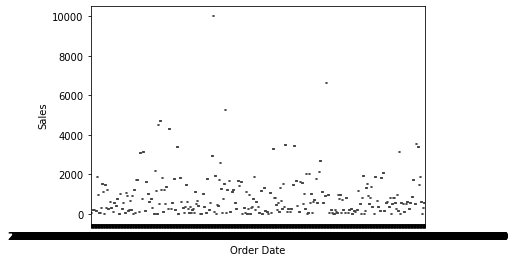

In [ ]:
import seaborn as sns
sns.boxplot(x=furniture['Order Date'],
            y=furniture['Sales'])

#Indexing time-series data


In [ ]:
furniture = furniture.set_index('Order Date')
#furniture = furniture.apply(lambda x: x.set_index('Order Date'))
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [ ]:
# Averaging Daily Sales
y = furniture['Sales'].resample('MS').mean()

In [ ]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

#Furniture data time-series visualization

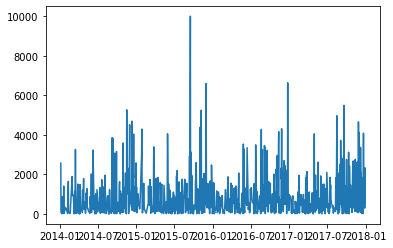

In [ ]:
plt.plot(furniture['Sales'])

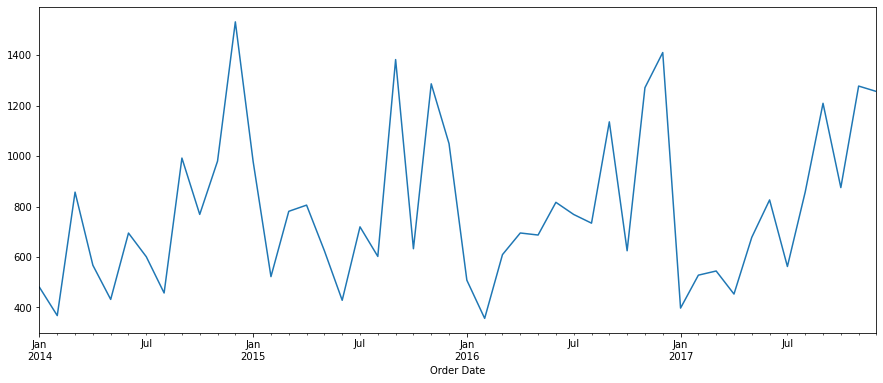

In [ ]:
y.plot(figsize=(15, 6))

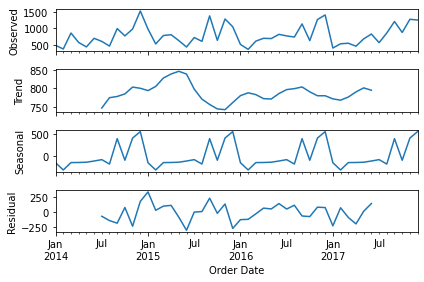

In [ ]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
decomposition.plot()
plt.show()

The above plot shows that the sales of furniture is highly unstable with seasonality and trend easily observable.

#Time series forecasting with ARIMA Model

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

print('Few parameter combinations are:')
print('{} x {}'.format(pdq[1], seasonal_pdq[1]))
print('{} x {}'.format(pdq[2], seasonal_pdq[2]))

Few parameter combinations are:
(0, 0, 1) x (0, 0, 1, 12)
(0, 1, 0) x (0, 1, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(y, order=param, seasonal_order=param_seasonal, enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = model.fit()
            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1465.324747812899
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:497.2314433418337


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1251.9866263898775
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:720.9252270758102
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2902.0056507195513
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:466.56074298091676


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:499.5702446844217
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2400.364309996122
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:319.9884876946871
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:677.894766859465


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1467.7189761276309
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:486.63785671879367
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:497.78896630044073


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1024.367167837936
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:649.9056176817456
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:2623.736390923739
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:458.8705548482636
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:486.1832977442739
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:2845.1395120221937
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:310.757436841719
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:692.1645522067712
ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:1410.1149571960532
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:479.46321478521355


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:480.9259367935196


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:1114.2026757573515
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:304.46646750846014
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:665.7794442185216
ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:326397302.97901773
ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:468.36851958141426
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:482.57633238769296


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:nan
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:306.0156002152007
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:671.2513547541902
ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1377.701968220998
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:479.2003422281135


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:475.3403658784892


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1451.3058168699715
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:300.6270901345398
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:649.0318019835429


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:nan
ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:460.4762687609859
ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:469.5250354660892


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:nan
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:297.7875439536804


In [ ]:
# Training the ARIMA model.
model = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12), enforce_stationarity=False,
                                            enforce_invertibility=False)
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


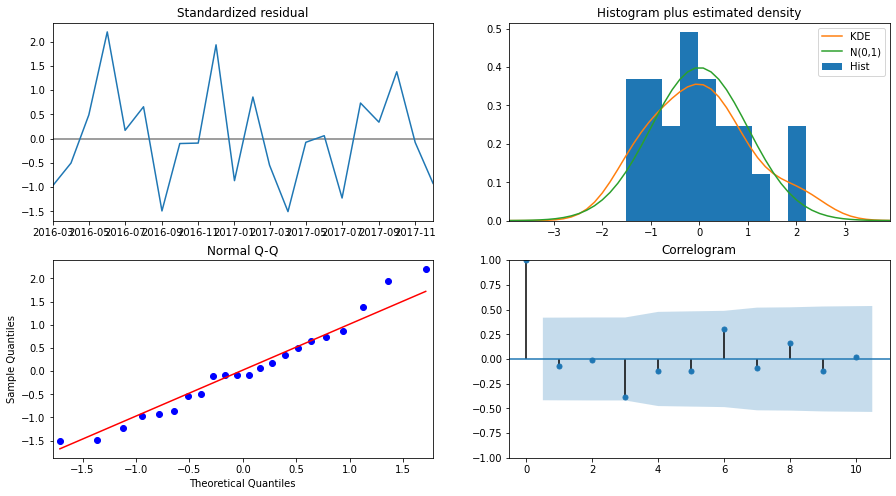

In [ ]:
results.plot_diagnostics(figsize=(15, 8))
plt.show()

The above plots suggest that the Model Residuals are nearly Normally Distributed.

#Validating the model forecasts




            lower Sales  upper Sales
Order Date                          
2017-01-01   204.676046   895.517901
2017-02-01    31.859781   721.913047
2017-03-01   296.215987   985.551784
2017-04-01   373.138178  1061.818419
2017-05-01   347.351617  1035.430532
2017-06-01   471.969293  1159.494649
2017-07-01   433.445474  1120.459563
2017-08-01   385.912455  1072.452900
2017-09-01   806.828522  1492.928941
2017-10-01   291.097935   976.788490
2017-11-01   948.687489  1633.995342
2017-12-01  1074.694553  1759.644252


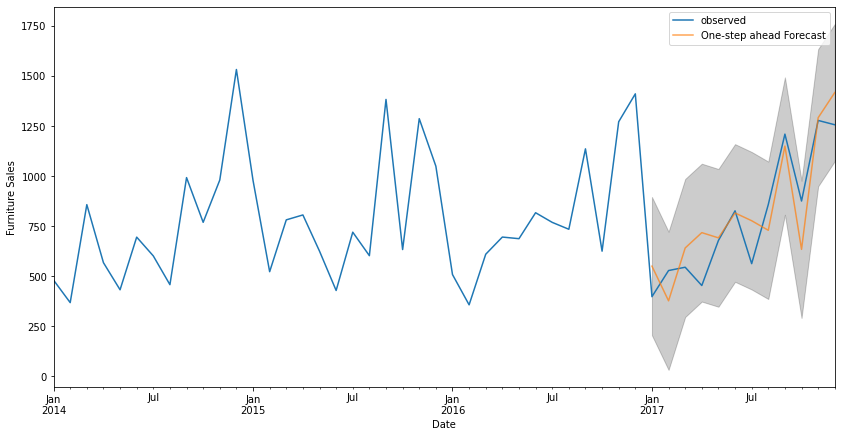

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
print(pred_ci)
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
y_predicted = pred.predicted_mean
y_true = y['2017-01-01':]
mse = ((y_predicted - y_true)**2).mean()
print('Mean Square Error is:', round(mse, 4))

Mean Square Error is: 22993.5691


In [ ]:
print('Root Mean Square Error is:', np.sqrt(mse))

Root Mean Square Error is: 151.63630546318495


#Future Forecasts

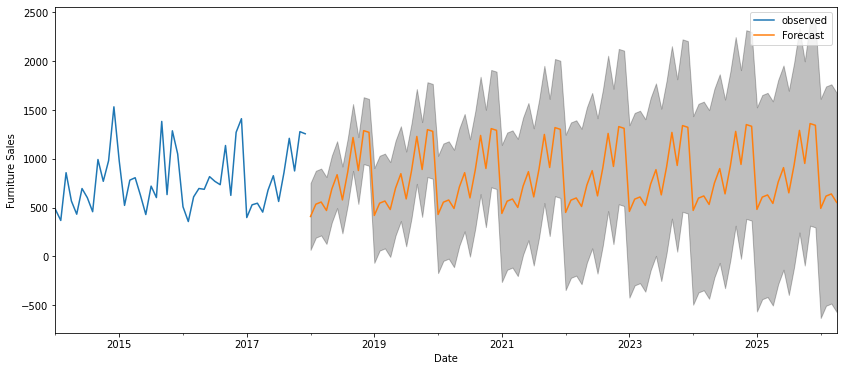

In [ ]:
# Forecasting the future (out of sample) values.
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

#Furniture vs Office Supplies

In [ ]:
furniture = dataset.loc[dataset['Category'] == 'Furniture']
office = dataset.loc[dataset['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

In [ ]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
office.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

furniture = pd.DataFrame({'Order Date':y_furniture.index, 'Sales':y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 'Sales': y_office.values})

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Merging both the time series comparison

In [ ]:
store = furniture.merge(office, on='Order Date', how='inner')
store.rename(columns={'Sales_x': 'Furniture Sales', 'Sales_y': 'Office Sales'}, inplace=True)
store.head()

,Order Date,Furniture Sales,Office Sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


#Visualizing Furniture vs Office Sales time series

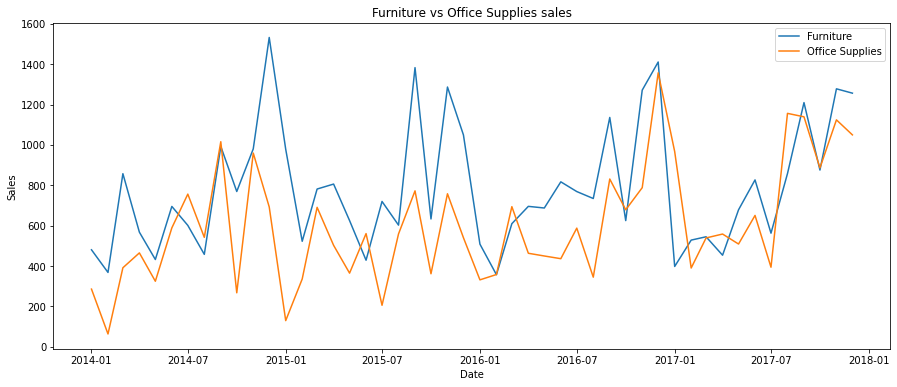

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(store['Order Date'], store['Furniture Sales'], label='Furniture')
plt.plot(store['Order Date'], store['Office Sales'], label='Office Supplies')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Furniture vs Office Supplies sales')
plt.legend()